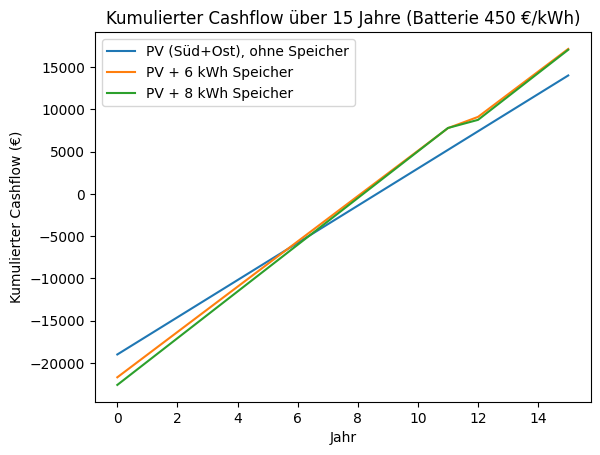

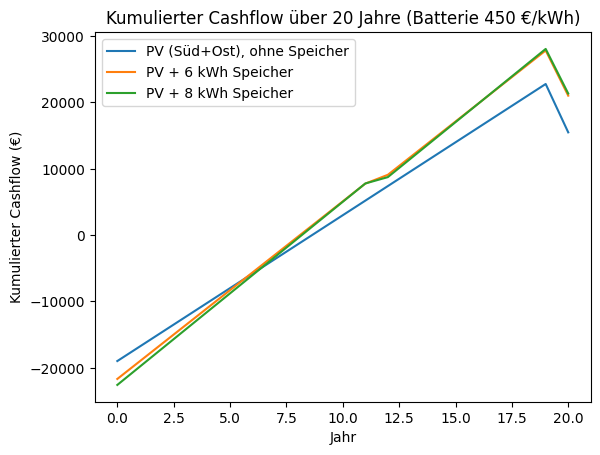

In [3]:
# Re-run the computation after environment reset
import math
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
area_south_m2 = 30
area_east_m2 = 44
density_kwp_per_m2 = 0.19

yield_south_kwh_per_kwp = 1000
yield_east_kwh_per_kwp = 900

price_grid = 0.34
feedin_tariff = 0.0796

capex_per_kwp = 1350
battery_cost_6 = 2700  # 6 kWh * 450 €/kWh
battery_cost_8 = 3600  # 8 kWh * 450 €/kWh

discount = 0.03
horizons = [15, 20]

# Derived PV size and yield
kwp_south = area_south_m2 * density_kwp_per_m2
kwp_east = area_east_m2 * density_kwp_per_m2
kwp_total = kwp_south + kwp_east

gen_total = kwp_south * yield_south_kwh_per_kwp + kwp_east * yield_east_kwh_per_kwp
load = 8000
pv_capex = kwp_total * capex_per_kwp

scenarios = [
    {"name": "PV (Süd+Ost), ohne Speicher", "autarky": 0.55, "capex_extra": 0, "battery_cost": 0},
    {"name": "PV + 6 kWh Speicher", "autarky": 0.78, "capex_extra": battery_cost_6, "battery_cost": battery_cost_6},
    {"name": "PV + 8 kWh Speicher", "autarky": 0.82, "capex_extra": battery_cost_8, "battery_cost": battery_cost_8},
]

def npv(cashflows, r):
    return sum(cf / ((1 + r) ** t) for t, cf in enumerate(cashflows))

def analyze(horizon_years):
    rows = []
    curves = {}
    for s in scenarios:
        capex0 = pv_capex + s["capex_extra"]
        cashflows = [-capex0]
        
        baseline_cost = load * price_grid
        self_consumed = min(gen_total, s["autarky"] * load)
        grid_import = load - self_consumed
        feedin = max(0, gen_total - self_consumed)
        annual_cost_with_pv = grid_import * price_grid - feedin * feedin_tariff
        annual_savings = baseline_cost - annual_cost_with_pv
        
        for year in range(1, horizon_years + 1):
            cf = annual_savings
            if s["battery_cost"] > 0 and year == 12:
                cf -= 0.5 * s["battery_cost"]
            if year == 20:
                cf -= 0.5 * pv_capex
            cashflows.append(cf)
        
        cum = 0
        curve = []
        for cf in cashflows:
            cum += cf
            curve.append(cum)
        curves[s["name"]] = curve
        
        payback = None
        cum2 = 0
        for t, cf in enumerate(cashflows):
            cum2 += cf
            if cum2 >= 0 and payback is None:
                payback = t
        
        rows.append({
            "Szenario": s["name"],
            "PV-Größe (kWp)": round(kwp_total, 1),
            "PV-Ertrag (kWh/a)": int(gen_total),
            "Autarkie (Annahme)": f"{int(s['autarky']*100)} %",
            "Start-Invest": int(capex0),
            "Jährliche Ersparnis": int(annual_savings),
            "Payback (Jahr)": payback if payback is not None else f"≥{horizon_years+1}",
            f"Summe Cashflow {horizon_years}J (ohne Abzinsung)": int(sum(cashflows)),
            f"NPV {horizon_years}J @3%": int(round(npv(cashflows, discount), 0)),
        })
    return pd.DataFrame(rows), curves

dfs = {}
curves_by_horizon = {}
for H in horizons:
    df, curves = analyze(H)
    dfs[H] = df
    curves_by_horizon[H] = curves

#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("15 Jahre (Batterie 450 €/kWh): Ergebnisse", dfs[15])
#display_dataframe_to_user("20 Jahre (Batterie 450 €/kWh): Ergebnisse", dfs[20])

plt.figure()
for name, curve in curves_by_horizon[15].items():
    plt.plot(range(0, 16), curve[:16], label=name)
plt.xlabel("Jahr")
plt.ylabel("Kumulierter Cashflow (€)")
plt.title("Kumulierter Cashflow über 15 Jahre (Batterie 450 €/kWh)")
plt.legend()
plt.show()

plt.figure()
for name, curve in curves_by_horizon[20].items():
    plt.plot(range(0, 21), curve[:21], label=name)
plt.xlabel("Jahr")
plt.ylabel("Kumulierter Cashflow (€)")
plt.title("Kumulierter Cashflow über 20 Jahre (Batterie 450 €/kWh)")
plt.legend()
plt.show()
